# Model Building

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

#ignore annoying warning (from sklearn and seaborn)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

In [2]:
data = pd.read_csv('data_cleaned.csv')
data.shape

(226230, 26)

In [3]:
data.head()

,region,price,type,sqfeet,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,...,has_pool,has_grill,has_fireplace,gym_nearby,school/clg_nearby,wifi_facilities,valet_service,shopping_nearby,sports_playground,dining_nearby
0,3.0,7.021084,4.0,7.184629,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,3.0,6.715383,4.0,7.032624,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,3.0,6.684612,4.0,6.831954,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,3.0,6.665684,4.0,6.953684,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4,3.0,6.802395,4.0,7.168580,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    data.drop('price',axis=1),
                                    data['price'],
                                    test_size=0.25,
                                    random_state=0)

***Data Split 1: all of our final dataset, no scaling***

In [5]:
y = data['price']
X = data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

***Data Split 2: all of our final dataset, with scaling***

In [6]:
sc_X = StandardScaler()

X2_train = sc_X.fit_transform(X_train)
X2_test = sc_X.fit_transform(X_test)
y2_train = y_train
y2_test = y_test

## Linear Regression

From our EDA, we can see that most features do not have a linear relationship with our labels (gdp_per_capita), yet we will try linear regression, and use the result as a reference (other methods should have better results).

***Model Training***

In [7]:
lm1 = LinearRegression()
lm1.fit(X_train,y_train)

lm2 = LinearRegression()
lm2.fit(X2_train,y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

***Predictions***

In [8]:
lm1_pred = lm1.predict(X_test)
lm2_pred = lm2.predict(X2_test)

***Evaluation***

Linear Regression Performance:

all features, No scaling:
MAE: 0.26438618763180477
RMSE: 0.44833199585287753
R2_Score:  0.14581630230324816

all features, with scaling:
MAE: 0.26448217103409666
RMSE: 0.4483412146065507
R2_Score:  0.14578117391565726


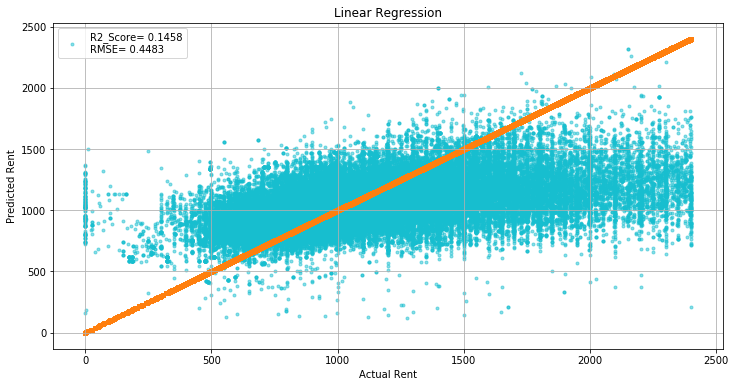

In [19]:
print('Linear Regression Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, lm1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lm1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, lm1_pred))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(y2_test, lm2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, lm2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, lm2_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(lm2_pred), 'Actual_Rent': np.exp(y2_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha='0.5')
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y2_test, lm2_pred), 
                np.sqrt(metrics.mean_squared_error(y2_test, lm2_pred)))
           ],
           loc='best')
plt.title('Linear Regression')
plt.grid()
plt.show()

The orange line in the graph represents the actual rents. And the cyan circles plotted against actual rents, on the x-axis, are the predicted rents.

Linear Model worked terribly, which was expected as there were no linear relationship among the features. Feature scaling has a small positive effect on LR's prediction performance.

## Random Forest

Let's first try random forest with our data splits (with and without feature selection). Scaling the features should not affect this algorithm's performance, still we are going to test it. later we will try to improve its performance.

***Model Training***

In [10]:
rf1 = RandomForestRegressor(random_state=101, n_estimators=200)
rf2 = RandomForestRegressor(random_state=101, n_estimators=200)

rf1.fit(X_train, y_train)
rf2.fit(X2_train, y2_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=101, verbose=0,
                      warm_start=False)

***Predictions***

In [11]:
rf1_pred = rf1.predict(X_test)
rf2_pred = rf2.predict(X2_test)

***Evaluation***

Random Forest Performance:

all features, No scaling:
MAE: 0.059128200788923446
RMSE: 0.1717131883398518
R2_Score:  0.8746976791953469

all features, with scaling:
MAE: 0.09880342151402599
RMSE: 0.26771296004208606
R2_Score:  0.6954275600449809


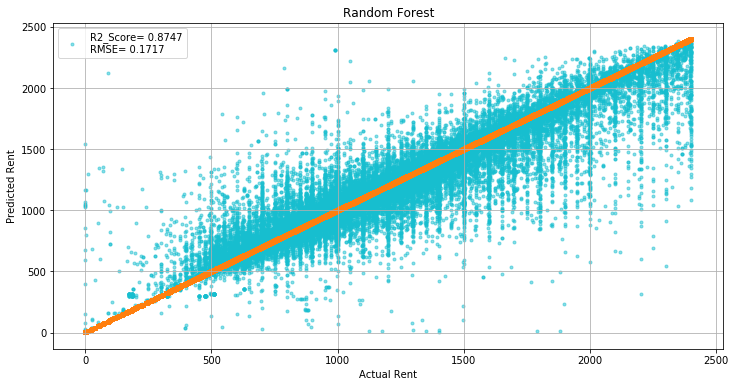

In [22]:
print('Random Forest Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, rf1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, rf1_pred))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(y2_test, rf2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, rf2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, rf2_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(rf1_pred), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha='0.5')
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y_test, rf1_pred), 
                np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
           ],
           loc='best')
plt.title('Random Forest')
plt.grid()
plt.show()

Features without scaling gave a better result on random forest than with scaled features


***Optimization***

We will use grid search in order to obtain good parameters for our RF regressor. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimiz are:

- n-estimators
- min_samples_leaf
- max_features
- bootstrap



In [13]:
rf_param_grid = {'max_features': ['sqrt', 'auto'],
                 'min_samples_split': [4, 6],
              'min_samples_leaf': [3, 5],
              'n_estimators': [100, 200],
             'bootstrap': [False, True]}

In [14]:
rf_grid = GridSearchCV(estimator= RandomForestRegressor(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)

In [15]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [False, True],


In [16]:
rf_grid.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 200}

In [17]:
rf_grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [18]:
rf_grid_predictions = rf_grid.predict(X_test)

MAE: 0.06493429871393701
RMSE: 0.17628598728027195
R2_Score:  0.8679351036117693


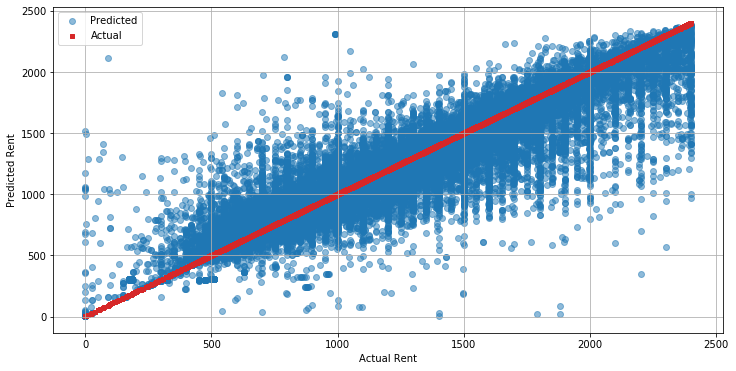

In [19]:
print('MAE:', metrics.mean_absolute_error(y_test, rf_grid_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_grid_predictions)))
print('R2_Score: ', metrics.r2_score(y_test, rf_grid_predictions))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(rf_grid_predictions), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha='0.5')
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y_test, rf_grid_predictions), 
                np.sqrt(metrics.mean_squared_error(y_test, rf_grid_predictions)))
           ],
           loc='best')
plt.title('Random Forest Optimized')
plt.grid()
plt.show()

We can see that the optimization process on RF regressor has not changed the performance in a noticebale manner, yet the slight change was actually to the worst, that is probably because our initial parameters were already very close to the optimum ones.

## Gradient Boosting

***Training***

In [20]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, 
                                 min_samples_leaf=1, max_depth=3, subsample=1.0, max_features= None, 
                                 random_state=101)

gbm1.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=101, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

***Predictions***

In [21]:
gbm1_pred = gbm1.predict(X_test)

***Evaluation***

Gradiant Boosting Performance:

all features, No scaling:
MAE: 0.17399878350381712
RMSE: 0.3158548488015822
R2_Score:  0.5760380245274421


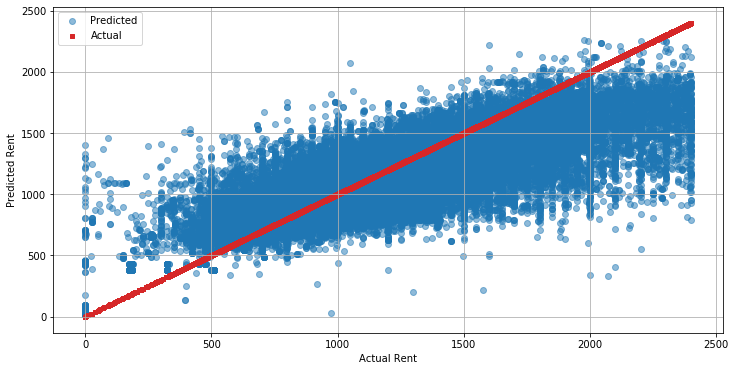

In [22]:
print('Gradiant Boosting Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, gbm1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gbm1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, gbm1_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(gbm1_pred), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha='0.5')
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y_test, gbm1_pred), 
                np.sqrt(metrics.mean_squared_error(y_test, gbm1_pred)))
           ],
           loc='best')
plt.title('Gradient Boosting')
plt.grid()
plt.show()

It is clear that Gradiant Boosting gave us a very poor performance, compared to Random Forest. So not opting for an optimization.

## XgBoost

***Model Training***

We will train the xgboost regressor with the default parameter values

In [23]:
xgb1 = XGBRegressor(learning_rate=0.1, n_estimators=100, 
                    min_samples_split=2, min_samples_leaf=1, 
                    max_depth=3, subsample=1.0, random_state=101)

xgb1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, min_samples_leaf=1, min_samples_split=2,
             missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             random_state=101, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method=None, validate_parameters=False,
             verbosity=None)

***Predictions***

In [24]:
xgb1_pred = xgb1.predict(X_test)

***Evaluation***

XgBoost Performance:

all features, No scaling:
MAE: 0.17325995858722668
RMSE: 0.316862668544094
R2_Score:  0.5733281790272069


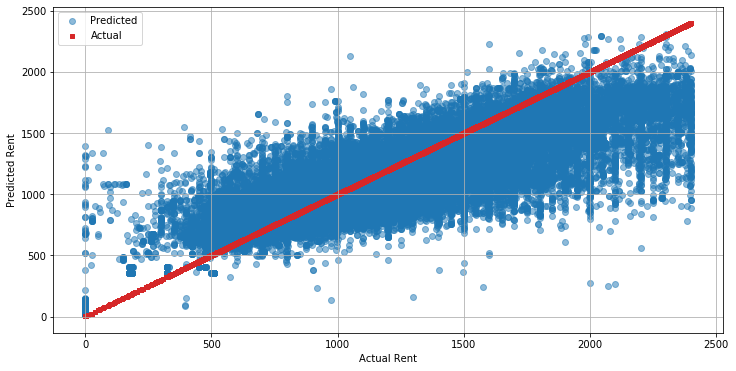

In [25]:
print('XgBoost Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, xgb1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, xgb1_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(xgb1_pred), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha='0.5')
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y_test, xgb1_pred), 
                np.sqrt(metrics.mean_squared_error(y_test, xgb1_pred)))
           ],
           loc='best')
plt.title('XgBoost')
plt.grid()
plt.show()

XgBoost also performed poorly. So will not be optimizing.

## Conclusion

In this project, we used house rent dataset to build a monthly rent predictor. 4 different learning regressors (Linear Regression, Random Forest, Gradiant Boosting, and XgBoost) were tested, and we have acheived the best prediction performance using Random Forest, followed by Gradiant Boosting, and then XgBoost, while Linear Regression, acheived the worst performance of the 4.

The best prediction performance was acheived using Random Forest regressor, using all features in the dataset, and resulted in the following metrics:

- Mean Absolute Error (MAE): 0.0591
- Root mean squared error (RMSE): 0.1717
- R-squared Score (R2_Score): 0.8746